In [1]:
import numpy as np
from scipy import linalg as la
import scipy
from imageio import imread
from matplotlib import pyplot as plt
import scipy.sparse.linalg

# Problem 1
def laplacian(A):
    """Compute the Laplacian matrix of the graph G that has adjacency matrix A.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.

    Returns:
        L ((N,N) ndarray): The Laplacian matrix of G.
    """
    
    return (np.diag(np.sum(A, axis=1)) - A)       #make a diagonal matrix where each entry is the sum 
                #of the corresponding row in A, and return the difference of A from this matrix
    

In [2]:
# Problem 2
def connectivity(A, tol=1e-8):
    """Compute the number of connected components in the graph G and its
    algebraic connectivity, given the adjacency matrix A of G.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.
        tol (float): Eigenvalues that are less than this tolerance are
            considered zero.

    Returns:
        (int): The number of connected components in G.
        (float): the algebraic connectivity of G.
    """
    L = laplacian(A)      #use our laplacian function to find the laplacian of A

    eigs = np.real(la.eig(L)[0])        #make a an array of the eigenvalues of L

    num_connected = 0

    for eigenvalue in eigs:
        if eigenvalue < tol:
            num_connected+=1         #count the number of eigenvalues less than zero

    new_eigs = np.delete(eigs, np.argmax(eigs))

    al_connectivity = np.min(new_eigs)     #delete the smallest element, and then find the new smallest element

    return num_connected, al_connectivity

In [3]:
# Helper function for problem 4.
def get_neighbors(index, radius, height, width):
    """Calculate the flattened indices of the pixels that are within the given
    distance of a central pixel, and their distances from the central pixel.

    Parameters:
        index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
        radius (float): Radius of the neighborhood around the central pixel.
        height (int): The height of the original image in pixels.
        width (int): The width of the original image in pixels.

    Returns:
        (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
        (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
    """
    # Calculate the original 2-D coordinates of the central pixel.
    row, col = index // width, index % width

    # Get a grid of possible candidates that are close to the central pixel.
    r = int(radius)
    x = np.arange(max(col - r, 0), min(col + r + 1, width))
    y = np.arange(max(row - r, 0), min(row + r + 1, height))
    X, Y = np.meshgrid(x, y)

    # Determine which candidates are within the given radius of the pixel.
    R = np.sqrt(((X - col)**2 + (Y - row)**2))
    mask = R < radius
    return (X[mask] + Y[mask]*width).astype(int), R[mask]

In [12]:
# Problems 3-6
class ImageSegmenter:
    """Class for storing and segmenting images."""

    # Problem 3
    def __init__(self, filename):
        """Read the image file. Store its brightness values as a flat array."""
        
        image = imread(filename)

        scaled = image / 255.       #scale the file and save it as an attribute

        self.scaled_image = scaled

        if np.ndim(scaled) == 3:
            self.brightness = scaled.mean(axis=2)         #if the image is color, then compute brightness matrix by averaging rgb values at each pixel

        else:
            self.brightness = self.scaled_image           
        
        self.flat_brightness = np.ravel(self.brightness)    #flatten brightness matrix into 1D array

    # Problem 3
    def show_original(self):
        """Display the original image."""
        

        if np.ndim(self.scaled_image) >= 3:          #if the image is color, then plot it normally
            plt.imshow(self.scaled_image)
            plt.axis('off')

        else:
            plt.imshow(self.scaled_image, cmap="gray")       #if the image is grayscale, then use grayscale in the plotting
            plt.axis("off")

        plt.show()
        
        # Problem 4
    def adjacency(self, r=5., sigma_B2=.02, sigma_X2=3.):
        """Compute the Adjacency and Degree matrices for the image graph."""

        A = scipy.sparse.lil_matrix((len(self.flat_brightness), len(self.flat_brightness)))    #initialize A as a sparse matrix 
        m,n = A.shape
        D = np.empty(m)                #initialize D as an empty vector with the correct amount of elements
        height, width = self.brightness.shape       #get the the correct height and width for the get_neighbors function
        brightness_dis = []

        for i in range(0, m):
            brightness_dis = []
            weights = []
            indices, distances = get_neighbors(i, r, height, width)        #use the get neighbors functions to get the distances and indices from the central pixel
            for index in indices:
                brightness_dis.append(abs(self.flat_brightness[i] - self.flat_brightness[index]))     #make a list of the distances
            for j, b_dis in enumerate(brightness_dis):
                weights.append(np.e **(-b_dis/sigma_B2 - (distances[j] / sigma_X2)))         #make a list of the weights using the formula from the lab file
            A[i, indices] = weights            #store the weights in A
            D[i] = sum(weights)                #set the ith element of D to the sum of the weights

        return scipy.sparse.csc_matrix(A), D
    
    # Problem 5
    def cut(self, A, D):
        """Compute the boolean mask that segments the image."""

        L = scipy.sparse.csgraph.laplacian(A)        #find the Laplacian of A

        exponents = np.power(D, -.5)                 #convert D to D^-1/2 by taking each entry to the -1/2 power 

        sparse_diag = scipy.sparse.diags(exponents)       #create a sparse diagonal matrix out of the entries of the converted D

        special_matrix = sparse_diag @ (L @ sparse_diag)      #multiply the matrices according to the formula in the lab file

        vals, vecs = scipy.sparse.linalg.eigsh(special_matrix, which='SM', k=2)      #find the two smallest eigenvalues and their eigenvectors of the matrix

        desired_vec = vecs[:, 1]                                     #store the eigenvector corresponding to the second smallest eigenvalue

        desired_vec = desired_vec.reshape(self.brightness.shape)         #reshape this eigenvector to align with the original image

        mask = desired_vec > 0                                  #get and return the boolean mask

        return mask
    
    # Problem 6
    def segment(self, r=5., sigma_B=.02, sigma_X=3.):
        """Display the original image and its segments."""

        A, D = self.adjacency(r, sigma_B, sigma_X)      #compute the adjancency and degree matrices
        mask = self.cut(A, D)                           #compute the boolean mask that segments the image
        inv_mask = ~mask 

        if self.scaled_image.ndim < 3:                  #if the image is gray, plot it in grayscale
            plt.subplot(131)
            plt.imshow(self.scaled_image, cmap="gray")
            plt.axis("off")

            plt.subplot(132)
            plt.imshow(self.scaled_image * mask, cmap="gray")
            plt.axis("off")

            plt.subplot(133)
            plt.imshow(self.scaled_image * inv_mask, cmap="gray")
            plt.axis("off")

        else:
            mask = np.dstack((mask, mask, mask))            #if the image is in color, plot it normally
            inv_mask = ~mask

            plt.subplot(131)
            plt.imshow(self.scaled_image)
            plt.axis("off")

            plt.subplot(132)
            plt.imshow(self.scaled_image * mask)
            plt.axis("off")

            plt.subplot(133)
            plt.imshow(self.scaled_image * inv_mask)
            plt.axis("off")

        plt.show()

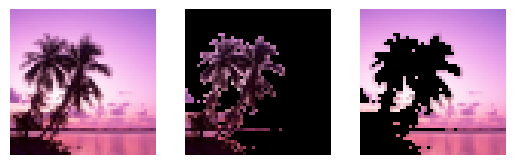

In [13]:
example = ImageSegmenter('dream.png')
example.segment()